In [23]:
#importing libraries

#core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Data & model
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier  #Model_in_use
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline

#Metrics and plots  #evaluating model performance
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, roc_auc_score,RocCurveDisplay,PrecisionRecallDisplay
)

#utilities
from sklearn.preprocessing import label_binarize #convert multiclass labels to binary format for ROC AUC
import joblib
import sklearn
from sklearn.metrics import RocCurveDisplay
print("sklearn version:", sklearn.__version__)

sklearn version: 1.0.2


In [10]:
#Load data

#loading dataset
iris=load_iris()
X=iris.data
y=iris.target
class_names = iris.target_names

print("Features shape",X.shape)
print("Classes",class_names)

Features shape (150, 4)
Classes ['setosa' 'versicolor' 'virginica']


In [11]:
#split into train/test sets(80/20 split)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train_size:", X_train.shape[0], "Test_size:",X_test.shape[0])

Train_size: 120 Test_size: 30


In [14]:
#Define Model and Grid search

#define_base_model
rf= RandomForestClassifier(random_state=42)

#creating_pipeline
pipe=Pipeline(steps=[
    ("rf",rf)
])

#define parameter grod for GridsearchCV
param_grid={
    'rf__n_estimators': [100,300],
    'rf__max_depth':[None,5,10],
    'rf__min_samples_split':[2,5],
    'rf__min_samples_leaf':[1,2],
    "rf__max_features":["sqrt","log2"]
}

cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

#metrics_to_evaluate
scoring={
    "accuracy":"accuracy", 
    "f1_macro":"f1_macro", 
    "precision_macro":"precision_macro", 
    "recall_macro": "recall_macro", 
    "roc_auc_ovr": "roc_auc_ovr" #multiclass AUC via OvR
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, refit= "f1_macro", cv=cv,
                    n_jobs=-1, return_train_score=False)


In [18]:
#Run grid search with 5 fold cv

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV f1_macro: {:.4f}".format(grid.best_score_))

#show_best_results

cv_results = pd.DataFrame(grid.cv_results_)
cols_to_show=[
    "mean_test_accuracy", "mean_test_f1_macro", "mean_test_precision_macro", "mean_test_recall_macro", "mean_test_roc_auc_ovr",
    "param_rf__n_estimators", "param_rf__max_depth", "param_rf__min_samples_split", "param_rf__min_samples_leaf",
    "param_rf__max_features"
]
display(cv_results.sort_values("mean_test_f1_macro", ascending=False) [cols_to_show].head(10))

Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best CV f1_macro: 0.9663


,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,mean_test_roc_auc_ovr,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features
44,0.966667,0.966337,0.971852,0.966667,0.998958,100,10,2,2,log2
36,0.966667,0.966337,0.971852,0.966667,0.998958,100,10,2,2,sqrt
20,0.966667,0.966337,0.971852,0.966667,0.998958,100,5,2,2,sqrt
4,0.966667,0.966337,0.971852,0.966667,0.998958,100,None,2,2,sqrt
38,0.966667,0.966337,0.971852,0.966667,0.998958,100,10,5,2,sqrt
6,0.966667,0.966337,0.971852,0.966667,0.998958,100,None,5,2,sqrt
46,0.966667,0.966337,0.971852,0.966667,0.998958,100,10,5,2,log2
30,0.966667,0.966337,0.971852,0.966667,0.998958,100,5,5,2,log2
22,0.966667,0.966337,0.971852,0.966667,0.998958,100,5,5,2,sqrt
12,0.966667,0.966337,0.971852,0.966667,0.998958,100,None,2,2,log2


In [19]:
#Evaluate on the held out test set

best_model= grid.best_estimator_

#predictions and probabilities
y_pred= best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

#Scalar metrics(macro-averaged)

f1_macro= f1_score(y_test,y_pred, average="macro")
precision_macro= precision_score(y_test,y_pred, average="macro")
recall_macro= recall_score(y_test,y_pred,average="macro")
roc_auc_macro_ovr = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")

print(f"Test F1(macro): {f1_macro:.4f}")
print(f"Test Precision(macro): {precision_macro:.4f}")
print(f"Test Recall (macro): {recall_macro:.4f}")
print(f"Test ROC AUC (macro, OvR): {roc_auc_macro_ovr:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=class_names))


Test F1(macro): 0.9666
Test Precision(macro): 0.9697
Test Recall (macro): 0.9667
Test ROC AUC (macro, OvR): 0.9867

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



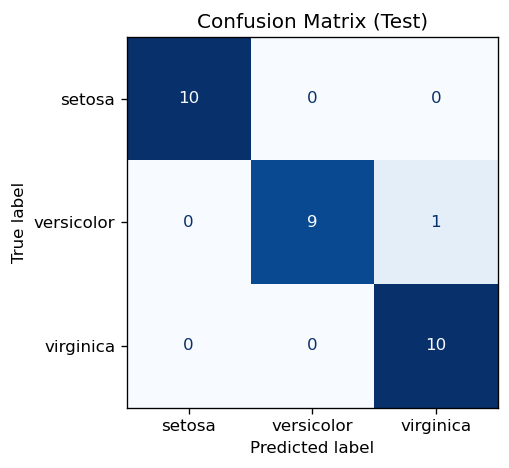

In [20]:
#confusion matrix


cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

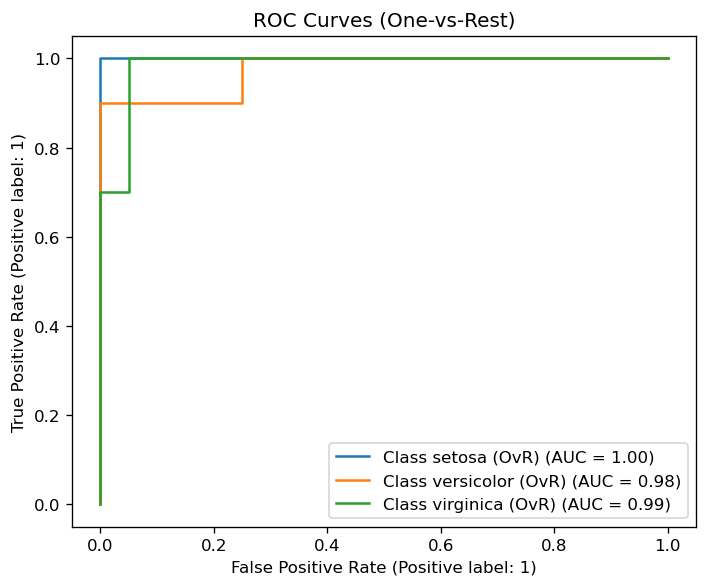

In [24]:
#ROC curve


# Ensuring probabilities are computed
y_proba = best_model.predict_proba(X_test)

# Binarize y for OvR
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_true=y_test_bin[:, i],    # true 0/1 for class i
        y_pred=y_proba[:, i],       # probability for class i
        name=f"Class {class_names[i]} (OvR)",
        ax=ax
    )

plt.title("ROC Curves (One-vs-Rest)")
plt.tight_layout()
plt.show()


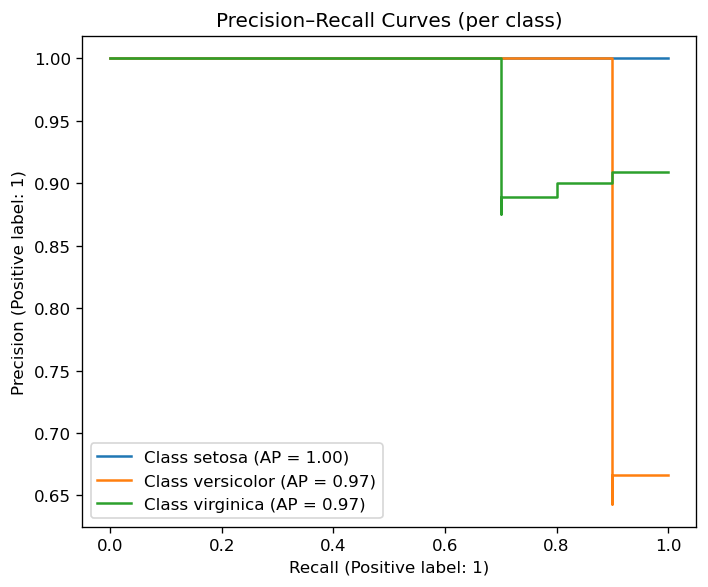

In [26]:
#Precision–Recall Curves (per class)

# Binarize labels for PR curves
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
for i in range(n_classes):
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:, i],
        y_proba[:, i],
        name=f"Class {class_names[i]}",
        ax=ax
    )

plt.title("Precision–Recall Curves (per class)")
plt.tight_layout()
plt.show()

In [28]:
#Saving the best model


joblib.dump(best_model, "RandomForest_iris_best_model.joblib")
print("Saved model to rf_iris_best_model.joblib")

Saved model to rf_iris_best_model.joblib
